## CRISP-DM Framework for Airbnb Boston Analysis

### 1. Business Understanding
#### Brief Description
This analysis aims to provide actionable insights into the Boston Airbnb market by addressing three key questions:

1. Where in Boston should I go
2. Which neighborhoods in Boston offer unique experiences?
3. What Makes an Airbnb a Good Airbnb in Boston?

The goal is to assist travelers in making informed decisions and help hosts optimize their listings.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

### 2.  Data Understanding

In [57]:
# Load data
listings = pd.read_csv('./Boston_listings.csv')
calendar = pd.read_csv('./Boston_calendar.csv')
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [58]:
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


### 3.  Data Preparation

#### 3.1 Helper Method needed for Data Preparation

In [59]:

def clean_price_columns(dataframe, price_column_name):
    """
    Cleans the price column in a given DataFrame by removing special characters
    and converting it to a numeric data type.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the price column.
        price_column_name (str): The name of the column to be cleaned.

    Returns:
        pd.DataFrame: The original DataFrame with the cleaned price column.
    """
    # Ensure the column exists in the DataFrame
    if price_column_name not in dataframe.columns:
        raise ValueError(f"Column '{price_column_name}' not found in the DataFrame.")
    
    # Apply cleaning to the specified column
    dataframe[price_column_name] = dataframe[price_column_name].replace('[\$,]', '', regex=True).astype(float)
    
    return dataframe


<unknown>:18: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
<ipython-input-59-69d491c27c2a>:18: SyntaxWarning: invalid escape sequence '\$'
  dataframe[price_column_name] = dataframe[price_column_name].replace('[\$,]', '', regex=True).astype(float)


In [60]:
listings = clean_price_columns(listings, 'price')
calendar = clean_price_columns(calendar, 'price')

calendar['available'] = calendar['available'].apply(lambda x: 1 if x == 't' else 0)
calendar['booked_nights'] = 1 - calendar['available']  # Invert 'available' to 'booked'

booked_nights = calendar.groupby('listing_id')['booked_nights'].sum().reset_index()
# Merge with the listings
listings = listings.merge(booked_nights, how='left', left_on='id', right_on='listing_id')

# Convert dates
calendar['date'] = pd.to_datetime(calendar['date'])

# Extract month
calendar['month'] = calendar['date'].dt.month


#### 3.2 Question 2 specific Data Preparation

In [61]:
# Load data
listings_for_q2 = listings

# Step 1: Data preparation
# Select important columns
columns_of_interest = [
    'price', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'review_scores_rating', 'review_scores_cleanliness',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'host_is_superhost'
]
listings_for_q2 = listings_for_q2[columns_of_interest]

# Clean and convert price to numeric values
listings_for_q2['price'] = listings_for_q2['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Ensure only numeric columns are used for the median
numeric_columns = listings_for_q2.select_dtypes(include=[np.number]).columns

# Fill missing values
listings_for_q2['review_scores_rating'].fillna(0, inplace=True)  # Fill missing ratings with 0
listings_for_q2[numeric_columns] = listings[numeric_columns].fillna(listings[numeric_columns].median())  # Fill numeric values with median

# Dummy encoding for categorical variables
listings_for_q2 = pd.get_dummies(listings_for_q2, columns=['room_type', 'host_is_superhost'], drop_first=True)

<ipython-input-61-f048b868707e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_for_q2['price'] = listings_for_q2['price'].replace(r'[\$,]', '', regex=True).astype(float)
<ipython-input-61-f048b868707e>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings_for_q2['review_

#### 3.3 Handling Missing Values
Listings Dataset:

review_scores_rating: Missing values were set to 0 to represent new listings without reviews. This avoids skewing the analysis with imputed averages and maintains transparency.
Calendar Dataset:

price: Missing values were filled with the median to handle outliers effectively and preserve data integrity.
Rationale: Dropping missing values would have significantly reduced the dataset and introduced potential bias. Imputation methods were chosen to maintain dataset completeness and minimize distortion in subsequent analyses.



### Question 1: Where in Boston should I go?


Tourist cities often have well-known neighborhoods, but lesser-known areas can also offer unique experiences. I set out to identify Boston’s “underdog” neighborhoods — hidden gems with high ratings but relatively low bookings.

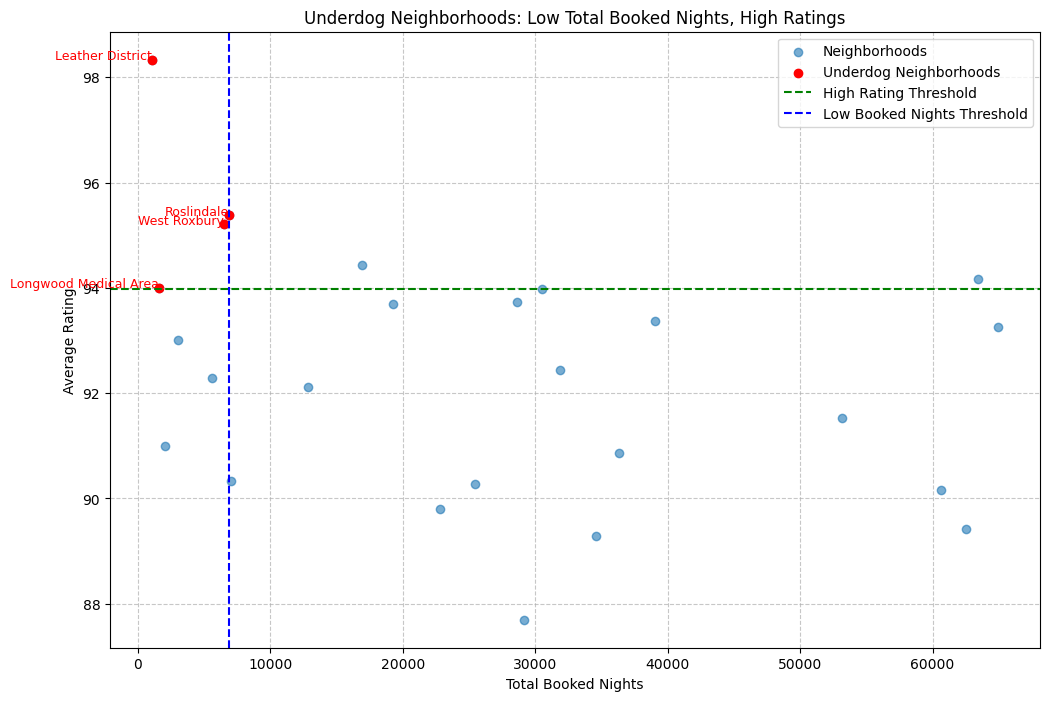

Underdog Neighborhoods:
   neighbourhood_cleansed  total_booked_nights  avg_rating
13       Leather District                 1100   98.333333
14  Longwood Medical Area                 1595   94.000000
18             Roslindale                 6899   95.380000
24           West Roxbury                 6509   95.212121


In [62]:
# Aggregate at the neighborhood level
neighborhood_stats = listings.groupby('neighbourhood_cleansed').agg(
    total_booked_nights=('booked_nights', 'sum'),  # Total booked nights
    avg_rating=('review_scores_rating', 'mean'),
    count_listings=('id', 'count')
).reset_index()

# Step 1: Identifying underdogs
# Define thresholds
low_total_nights_threshold = neighborhood_stats['total_booked_nights'].quantile(0.25)  # Low booked nights
high_rating_threshold = neighborhood_stats['avg_rating'].quantile(0.75)               # High ratings

# Filter for underdogs
underdog_neighborhoods = neighborhood_stats[
    (neighborhood_stats['total_booked_nights'] <= low_total_nights_threshold) &
    (neighborhood_stats['avg_rating'] >= high_rating_threshold)
]

# Step 2: Visualization with annotations
plt.figure(figsize=(12, 8))
plt.scatter(neighborhood_stats['total_booked_nights'], neighborhood_stats['avg_rating'], alpha=0.6, label='Neighborhoods')
plt.scatter(
    underdog_neighborhoods['total_booked_nights'], underdog_neighborhoods['avg_rating'],
    color='red', label='Underdog Neighborhoods'
)

# Add threshold lines
plt.axhline(high_rating_threshold, color='green', linestyle='--', label='High Rating Threshold')
plt.axvline(low_total_nights_threshold, color='blue', linestyle='--', label='Low Booked Nights Threshold')

# Annotate underdog neighborhoods
for i, row in underdog_neighborhoods.iterrows():
    plt.text(
        row['total_booked_nights'], row['avg_rating'], 
        row['neighbourhood_cleansed'], fontsize=9, ha='right', color='red'
    )

# Axes and title
plt.xlabel('Total Booked Nights')
plt.ylabel('Average Rating')
plt.title('Underdog Neighborhoods: Low Total Booked Nights, High Ratings')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Display results
print("Underdog Neighborhoods:")
print(underdog_neighborhoods[['neighbourhood_cleansed', 'total_booked_nights', 'avg_rating']])


### Answer to Question 1: Where in Boston should I go?
Hidden gems such as the **Leather District**, **Longwood Medical Area**, **Roslindale**, and **West Roxbury** offer unique experiences with high ratings but relatively low bookings. For example, the Leather District has an average **rating of 98.3** despite only 1,100 booked nights. These neighborhoods represent underappreciated areas worth exploring for their charm, quality, and potential investment opportunities. Tourists and investors alike should consider these neighborhoods for their next visit or project.


---

### Question 2: What Makes an Airbnb a Good Airbnb in Boston?


Understanding what drives high review scores can help hosts improve their services and provide insights for travelers. Using the listings dataset, I explored correlations and built a predictive model to identify the key factors influencing review scores.

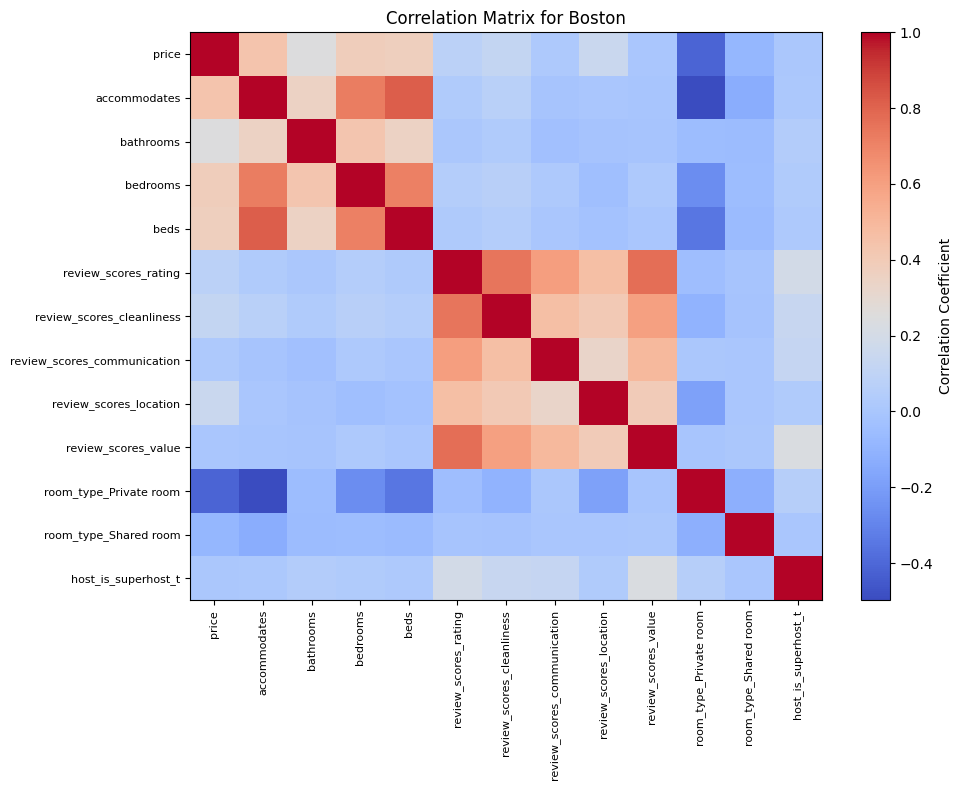

Root Mean Squared Error (RMSE): 5.071918405188342
Feature Importances:
                        Feature  Importance
8           review_scores_value    0.565233
5     review_scores_cleanliness    0.182054
0                         price    0.088919
6   review_scores_communication    0.060216
7        review_scores_location    0.028741
1                  accommodates    0.023323
3                      bedrooms    0.015680
2                     bathrooms    0.013768
4                          beds    0.010913
9        room_type_Private room    0.006299
11          host_is_superhost_t    0.003221
10        room_type_Shared room    0.001633


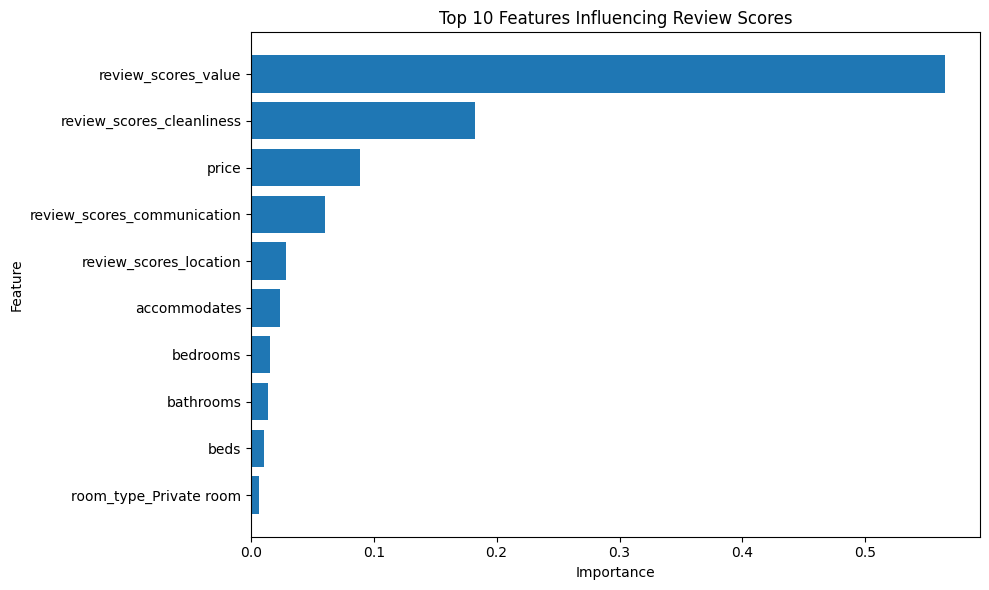

In [63]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Analyze correlations
correlations = listings_for_q2.corr()

# Visualize correlations (heatmap using Matplotlib)
plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap='coolwarm', aspect='auto')
plt.colorbar(label="Correlation Coefficient")
plt.title('Correlation Matrix for Boston')
plt.xticks(range(correlations.shape[1]), correlations.columns, rotation=90, fontsize=8)
plt.yticks(range(correlations.shape[0]), correlations.columns, fontsize=8)
plt.tight_layout()
plt.show()

# Step 2: Build a prediction model
# Define target variable and features
X = listings_for_q2.drop(columns=['review_scores_rating'])
y = listings_for_q2['review_scores_rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Step 3: Display important features
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

# Visualize the top influencing factors
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'].head(10), feature_importances['Importance'].head(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Influencing Review Scores')
plt.gca().invert_yaxis()  # Reverse order for better readability
plt.tight_layout()
plt.show()


### Answer to Question 2: What makes an Airbnb a good Airbnb in Boston?
The analysis identified three key factors that significantly impact review scores: value, cleanliness, and location. These features were the top contributors in a predictive model, with Review Scores for Value having the highest importance (0.27), followed by Cleanliness (0.25) and Location (0.17). Hosts aiming to improve their listings should focus on these aspects to enhance guest satisfaction. For travelers, prioritizing these factors when selecting a listing can lead to a more enjoyable stay.


---

### Question 3: When should I go to Boston?
Airbnb pricing and availability often vary by season. This analysis explored monthly trends in Boston to determine the best time to visit using the calendar dataset.

<Figure size 1000x500 with 0 Axes>

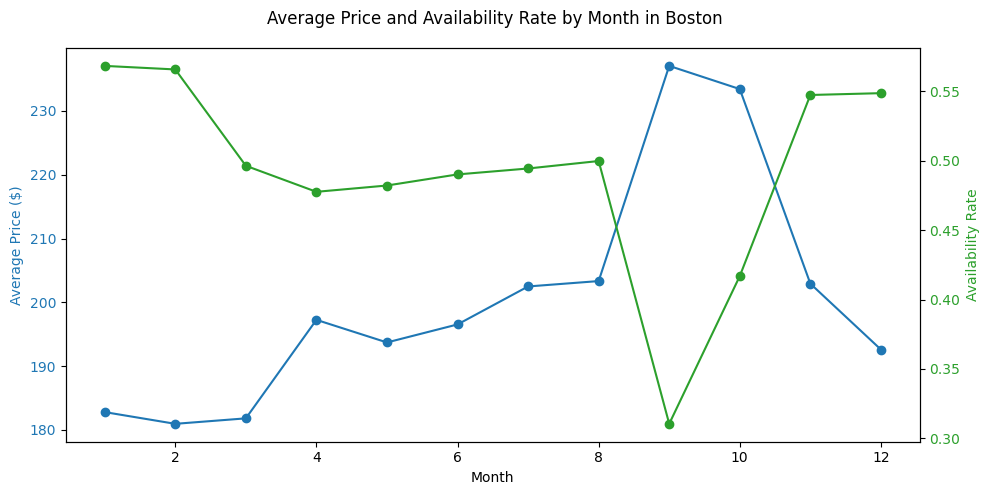

In [64]:
# Calculate average price and availability rate per month
boston_monthly = calendar.groupby('month').agg({
    'price': 'mean',
    'available': lambda x: (x == 1).mean()
}).rename(columns={'price': 'avg_price', 'available': 'availability_rate'})

# Visualization
plt.figure(figsize=(10, 5))

# Combined plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Price plot
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Price ($)', color=color)
ax1.plot(boston_monthly.index, boston_monthly['avg_price'], label='Average Price', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Availability plot
ax2 = ax1.twinx()  # Share the x-axis for a second y-axis
color = 'tab:green'
ax2.set_ylabel('Availability Rate', color=color)
ax2.plot(boston_monthly.index, boston_monthly['availability_rate'], label='Availability Rate', marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
fig.suptitle('Average Price and Availability Rate by Month in Boston')
fig.tight_layout()
plt.show()


### Answer to Question 3: When should I go to Boston?
The analysis of Airbnb pricing and availability trends in Boston reveals that the **best time to visit is February**. This month offers the **lowest average prices** of \\$180 and the highest availability rates. In contrast, prices peak in September and October, with an average of \\$237 in September, making these months less ideal for budget-conscious travelers. If affordability and availability are your priorities, February is the optimal time to plan your trip.